In [1]:
import random
import time
import warnings
from datetime import datetime

import torch
import os

import numpy as np
import warnings
np.warnings = warnings
import matplotlib.pyplot as plt
from tabpfn_new.scripts.differentiable_pfn_evaluation import eval_model_range
from tabpfn_new.scripts.model_builder import get_model, get_default_spec, save_model, load_model
from tabpfn_new.scripts.transformer_prediction_interface import transformer_predict, get_params_from_config, load_model_workflow

from tabpfn_new.scripts.model_configs import *

#from datasets import load_openml_list, open_cc_dids, open_cc_valid_dids
from tabpfn_new.priors.utils import plot_prior, plot_features
from tabpfn_new.priors.utils import uniform_int_sampler_f

from tabpfn_new.scripts.tabular_metrics import calculate_score_per_method, calculate_score
from tabpfn_new.scripts.tabular_evaluation import evaluate

from tabpfn_new.priors.differentiable_prior import DifferentiableHyperparameterList, draw_random_style, merge_style_with_info
from tabpfn_new.scripts import tabular_metrics
from tabpfn.notebook_utils import *

In [2]:
device = 'cpu'
base_path = '.'
max_features = 100

In [3]:
x = torch.rand((1000,4))
#print(torch.median(x, dim=0)[0])
b = (x>torch.median(x,dim=0)[0]).float()
#print(b)
print(torch.unique(b, return_counts=True))
for i in range(b.shape[1]):
    print(torch.unique(b[:,i], return_counts=True))


(tensor([0., 1.]), tensor([2000, 2000]))
(tensor([0., 1.]), tensor([500, 500]))
(tensor([0., 1.]), tensor([500, 500]))
(tensor([0., 1.]), tensor([500, 500]))
(tensor([0., 1.]), tensor([500, 500]))


In [4]:
def reload_config(prior_type='forest', config_type='causal', task_type='binary', longer=0):
    config = get_prior_config(config_type=config_type)
    
    config['prior_type'] = prior_type
    
    model_string = ''
    
    config['epochs'] = 12000
    config['recompute_attn'] = True

    config['max_num_classes'] = 10
    config['num_classes'] = uniform_int_sampler_f(2, config['max_num_classes'])
    config['balanced'] = False
    model_string = model_string + '_multiclass'
    
    model_string = model_string + '_'+datetime.now().strftime("%m_%d_%Y_%H_%M_%S")
    
    return config, model_string

In [12]:
prior_type = 'mlp'
config, model_string = reload_config(prior_type, longer=1)

config['differentiable'] = True
config['flexible'] = True
config['bptt_extra_samples'] = None

# diff
config['output_multiclass_ordered_p'] = 0.0
del config['differentiable_hyperparameters']['output_multiclass_ordered_p']



config['sampling'] = 'normal' # vielleicht schlecht?
del config['differentiable_hyperparameters']['sampling']

config['pre_sample_causes'] = True
# end diff

config['multiclass_loss_type'] = 'nono' # 'compatible'

config['categorical_feature_p'] = 0 # diff: .0

# turn this back on in a random search!?
config['nan_prob_no_reason'] = .0
config['nan_prob_unknown_reason'] = .0 # diff: .0
config['set_value_to_nan'] = .0 # diff: 1.


config['new_mlp_per_example'] = True
config['prior_mlp_scale_weights_sqrt'] = True
config['batch_size_per_gp_sample'] = None



config['differentiable_hps_as_style'] = False
config['max_eval_pos'] = 1000

config['random_feature_rotation'] = True
config['rotate_normalized_labels'] = True

config["mix_activations"] = True # False heisst eig True

config['emsize'] = 512
config['nhead'] = config['emsize'] // 128
config['bptt'] = 1024+128
config['canonical_y_encoder'] = False


config['total_available_time_in_s'] = None #60*60*22 # 22 hours for some safety...

config['train_mixed_precision'] = False
config['efficient_eval_masking'] = True

# mlp params
config['is_causal'] = True
config['num_causes'] = 5
config['prior_mlp_hidden_dim'] = 50
config['num_layers'] = 4
config['noise_std'] = 0.05
config['init_std'] = 0.05
config['y_is_effect'] = True
config['pre_sample_weights'] = True
config['prior_mlp_dropout_prob'] = 0
config['pre_sample_causes'] = True
config["prior_mlp_activations"] = torch.nn.ReLU
config["block_wise_dropout"] = True
config["sort_features"] = False
config["in_clique"] = False

# general data params
config['balanced'] = True
config['max_num_classes'] = 10
config['max_features'] = 100
config['num_features_used'] = 100

config['differentiable'] = True
config['flexible'] = True

# forest params
config["min_features"] = 100
config["max_features"] = 100
config["n_samples"] = 1000
config["max_num_classes"] = 2
config["base_size"] = 1000
config["n_estimators"] = 1
config["min_depth"] = 1
config["max_depth"] = 25
config["categorical_x"] = False
config["data_sample_func"] = "zinb"
config["comp"] = True

config['no_encoder'] = False
config['normalize_to_ranking'] = False # False
config['normalize_with_sqrt'] = False
config['normalize_ignore_label_too'] = False
config["normalize"] = False
config['num_classes'] = 2

config["balanced"] = True
config['multiclass_type'] = 'imbalanced_binarize'
del config['differentiable_hyperparameters']['multiclass_type']

config["prior_type"] = "forest"
config["microbiome_test"] = True
config["weight_classes"] = False
config["run_name"] = "forest_fullbalance_noweight"

    
config['aggregate_k_gradients'] = 16
config['batch_size'] = 4*config['aggregate_k_gradients']
config['num_steps'] = 4*config['aggregate_k_gradients']//config['aggregate_k_gradients']
config['epochs'] = 50

config["lr"] = 1e-6

config_sample = evaluate_hypers(config)
'''for key in config_sample:
    #if key == "check_is_compatible":
    print(key, config_sample[key])
for key in config_sample["differentiable_hyperparameters"]:
    print(key, config_sample["differentiable_hyperparameters"][key])'''

'for key in config_sample:\n    #if key == "check_is_compatible":\n    print(key, config_sample[key])\nfor key in config_sample["differentiable_hyperparameters"]:\n    print(key, config_sample["differentiable_hyperparameters"][key])'

In [ ]:
model = get_model(config_sample, device, should_train=True, verbose=1)

Using style prior: True
Using cpu:0 device
Using a Transformer with 25.81 M parameters


% Positive predictions:
1.000  1.000  1.000  1.000  
% Positive targets:
0.501  0.499  0.500  0.501  
Train sample accuracy: 0.500


% Positive predictions:
0.996  0.915  0.989  0.961  
% Positive targets:
0.500  0.499  0.500  0.500  
Train sample accuracy: 0.499


% Positive predictions:
0.752  0.486  0.310  0.562  
% Positive targets:
0.503  0.500  0.500  0.503  
Train sample accuracy: 0.486


% Positive predictions:
0.043  0.093  0.189  0.158  
% Positive targets:
0.500  0.500  0.500  0.500  
Train sample accuracy: 0.486


% Positive predictions:
0.078  0.014  0.001  0.035  
% Positive targets:
0.500  0.500  0.500  0.500  
Train sample accuracy: 0.503


% Positive predictions:
0.057  0.022  0.000  0.029  
% Positive targets:
0.498  0.502  0.498  0.505  
Train sample accuracy: 0.497


% Positive predictions:
0.092  0.004  0.033  0.150  
% Positive targets:
0.500  0.500  0.500  0.496  
Train sampl

In [7]:
import os
def load_train_results(name):
    dir_path = os.path.abspath(os.getcwd())
    path = dir_path + f"/logs/trainrun_{name}"
    losses = torch.load(path+"/losses")
    mb_results = torch.load(path+"/mb_results")
    return losses, mb_results

In [8]:
def plot_metrics(losses, results, metrics, name):
    plt.figure(1)
    plt.subplot(211)
    for ii, m in enumerate(metrics):
        plt.plot(results[:,ii], label=m)
    plt.ylabel("score")
    plt.title(name)
    plt.legend()
    plt.subplot(212)
    plt.plot(losses)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.show()

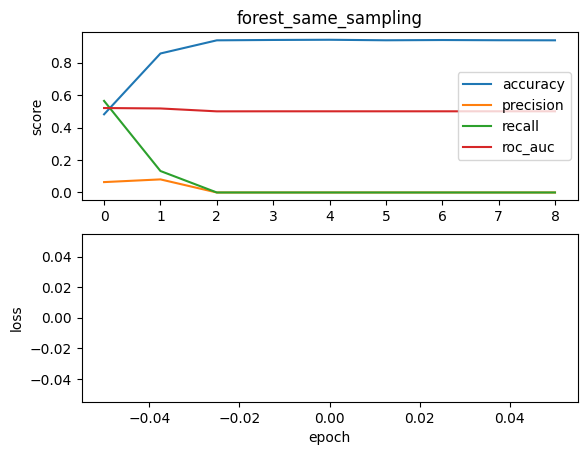

In [9]:
name = "forest_same_sampling"
metrics = ["accuracy", "precision", "recall", "roc_auc"]
losses, mb_results = load_train_results(name)
plot_metrics(losses, mb_results, metrics, name)

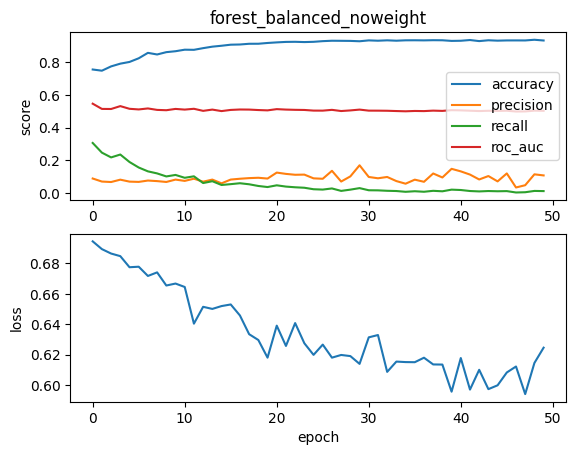

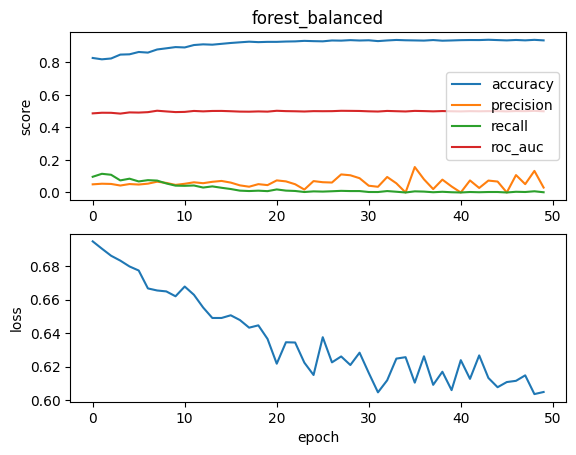

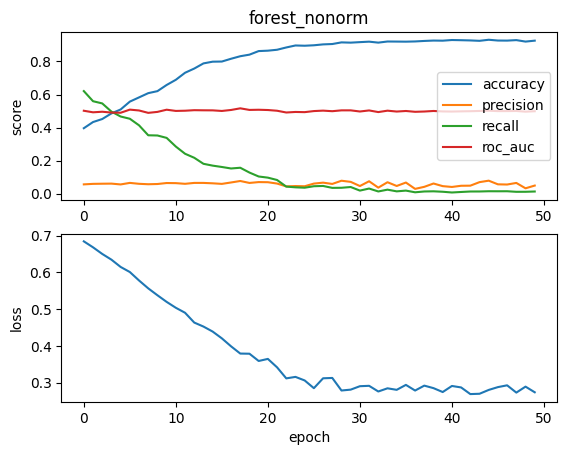

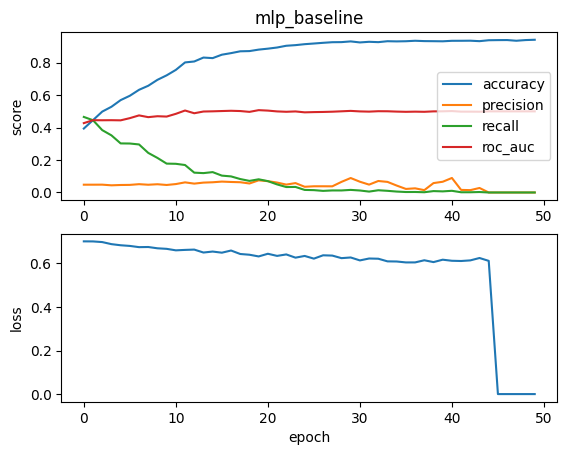

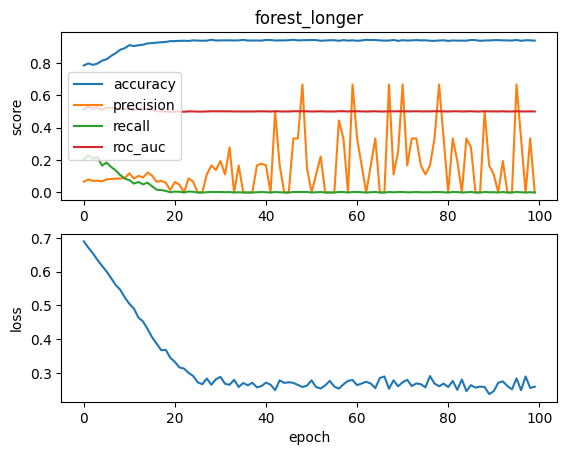

In [10]:
names = [
        "forest_balanced_noweight",
        "forest_balanced",
        "forest_nonorm",
        "mlp_baseline",
        "forest_longer"]
metrics = ["accuracy", "precision", "recall", "roc_auc"]
for name in names:
    losses, mb_results = load_train_results(name)
    plot_metrics(losses, mb_results, metrics, name)

In [11]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
b = torch.randint(0,2,(100,2))
a = torch.rand((100,2,3))
a[3,0,:] = 100

for i in range(20):
    split = torch.randint(8,100,(1,))
    sss = StratifiedShuffleSplit(n_splits=1, test_size = a.shape[0]-split)
    sss.get_n_splits(a,b)
    
    train_index, test_index= next(sss.split(a,b))
    X_train, y_train, X_test, y_test = a[train_index], b[train_index], a[test_index], b[test_index]
    #print(X_train, X_test)
    print(torch.where(X_train>10)[1])
    print(torch.where(X_test>10)[1])
    #print(split)
    #print(y_test.shape)
    #for i in range(2):
        #print(torch.unique(y_train[:,i], return_counts=True)[1]/y_train.shape[0])
        #print(torch.unique(y_test[:,i], return_counts=True)[1]/y_test.shape[0])
    X = torch.cat((X_train,X_test), dim=0)
    y = torch.cat((y_train,y_test), dim=0)

tensor([0, 0, 0])
tensor([], dtype=torch.int64)
tensor([], dtype=torch.int64)
tensor([0, 0, 0])
tensor([0, 0, 0])
tensor([], dtype=torch.int64)
tensor([], dtype=torch.int64)
tensor([0, 0, 0])
tensor([], dtype=torch.int64)
tensor([0, 0, 0])
tensor([], dtype=torch.int64)
tensor([0, 0, 0])
tensor([0, 0, 0])
tensor([], dtype=torch.int64)
tensor([], dtype=torch.int64)
tensor([0, 0, 0])
tensor([0, 0, 0])
tensor([], dtype=torch.int64)
tensor([0, 0, 0])
tensor([], dtype=torch.int64)
tensor([], dtype=torch.int64)
tensor([0, 0, 0])
tensor([0, 0, 0])
tensor([], dtype=torch.int64)
tensor([0, 0, 0])
tensor([], dtype=torch.int64)
tensor([], dtype=torch.int64)
tensor([0, 0, 0])
tensor([0, 0, 0])
tensor([], dtype=torch.int64)
tensor([0, 0, 0])
tensor([], dtype=torch.int64)
tensor([], dtype=torch.int64)
tensor([0, 0, 0])
tensor([], dtype=torch.int64)
tensor([0, 0, 0])
tensor([0, 0, 0])
tensor([], dtype=torch.int64)
tensor([0, 0, 0])
tensor([], dtype=torch.int64)
